# Graph analysis for PISA data

## Overview

This notebook performs various analyses on cell count data from different experimental groups. The primary tasks include:

1. **Loading Data**: Importing and cleaning cell count data.
2. **Statistical Analysis**: Performing statistical tests to identify significant areas.
3. **Graph Creation**: Generating and visualizing graphs based on correlation matrices.
4. **Data Visualization**: Creating histograms, boxplots, and other visualizations to analyze data distributions.

## Detailed Steps

**1. Load Data**

The notebook begins by loading and cleaning the volumes data using a custom function. It also loads results from a file and organizes experimental groups based on the subjects.

**2. Define Parameters**

- **Correlation Threshold**: A threshold for filtering correlations.
- **Significant Areas**: Areas that show statistically significant differences based on predefined criteria.

**3. Calculate Values Across Groups**

Cell counts are computed across different experimental groups using specific functions that aggregate the data.

**4. Cross-Correlation and Save Results**

Cross-correlation matrices are computed for different experimental conditions (e.g., control, fam, unfam). Results are saved as CSV files for further analysis.

**5. Create Graphs**

Graphs are generated from the correlation matrices. The notebook uses functions to create and visualize these graphs, showing relationships between significant areas.

**6. Plot Graphs**

Graphs are plotted using various layouts to visualize the connections between significant areas. The layout used is a spring layout, which helps in visualizing the structure of the network.

**7. Histogram and Boxplot Analysis**

Histograms and boxplots are created to analyze the distribution of graph degrees and correlation values. This helps in understanding the statistical properties of the data.


In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import copy
import itertools
from utils_graphs import create_graph, plot_graph, get_colors, fig_graph_degrees
import utils_PLS as upls
import matplotlib.colors as cm
from matplotlib.lines import Line2D

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'PISA'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA_without_Pons.npy', allow_pickle=True).item()
batch='PISA'

# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12noshock']
del dict_results_across_mice['BL22demonstrator']
subjects = list(dict_results_across_mice.keys())

experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels=['noshock','demonstrator', 'observer'])

In [4]:
allen_order = list(volumes[volumes['st_level']==8]['acronym'])

In [6]:
df_levels = upls.create_df_levels(volumes, level=8)
macroareas_to_exclude = ['Medulla', 'Cerebellar cortex', 'Cerebellar nuclei', 'Pons']

In [7]:
df_levels


,area,name_area,parent_l5,name_parent_l5
0,FRP,Frontal pole cerebral cortex,Isocortex,Isocortex
1,MOp,Primary motor area,Isocortex,Isocortex
2,MOs,Secondary motor area,Isocortex,Isocortex
3,SSp,Primary somatosensory area,Isocortex,Isocortex
4,SSs,Supplemental somatosensory area,Isocortex,Isocortex
...,...,...,...,...
292,FL,Flocculus,CBX,Cerebellar cortex
293,FN,Fastigial nucleus,CBN,Cerebellar nuclei
294,IP,Interposed nucleus,CBN,Cerebellar nuclei
295,DN,Dentate nucleus,CBN,Cerebellar nuclei


In [8]:
significant_areas = ace.select_significant_areas(dictionary=dict_results_across_mice, 
                                             experimental_groups=experimental_groups, 
                                             batch=batch,
                                             test='mannwhitneyu', 
                                             threshold_test=0.05,
                                             threshold_pls=2.56,
                                             value_test='density', 
                                             value_pls='relative_density')

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [9]:
df_noshock, df_demonstrator, df_observer = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='density')


In [10]:
corr_matrix_noshock = ace.cross_corr(df_noshock)
corr_matrix_demonstrator = ace.cross_corr(df_demonstrator)
corr_matrix_observer = ace.cross_corr(df_observer)

In [11]:
corr_threshold = 0.95
G_noshock = create_graph(corr_matrix_noshock, volumes=volumes, 
                         significant_areas=significant_areas, 
                         corr_threshold=corr_threshold, correlations='one')

G_demonstrator = create_graph(corr_matrix_demonstrator,  volumes=volumes, 
                         significant_areas=significant_areas, 
                         corr_threshold=corr_threshold, correlations='one')

G_observer = create_graph(corr_matrix_observer,  volumes=volumes, 
                         significant_areas=significant_areas, 
                         corr_threshold=corr_threshold, correlations='one')

## Graphs of positive correlations

(<Figure size 1656x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb3d9af9f60>)

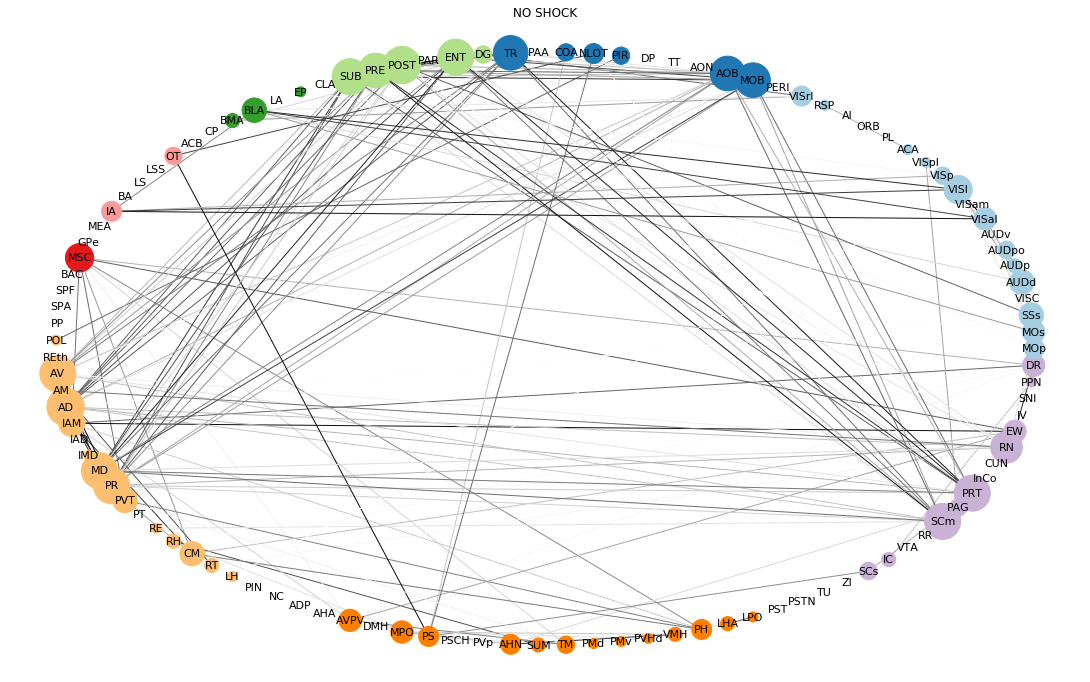

In [12]:
fig_graph_degrees(G=G_noshock, title='NO SHOCK', volumes=volumes, figsize=(23,12), 
                  show_degrees=False, show_colorbar=False, show_legend=False, fontsize=11,
                 macroareas_to_exclude=macroareas_to_exclude)

(<Figure size 1656x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb3d8abbd68>)

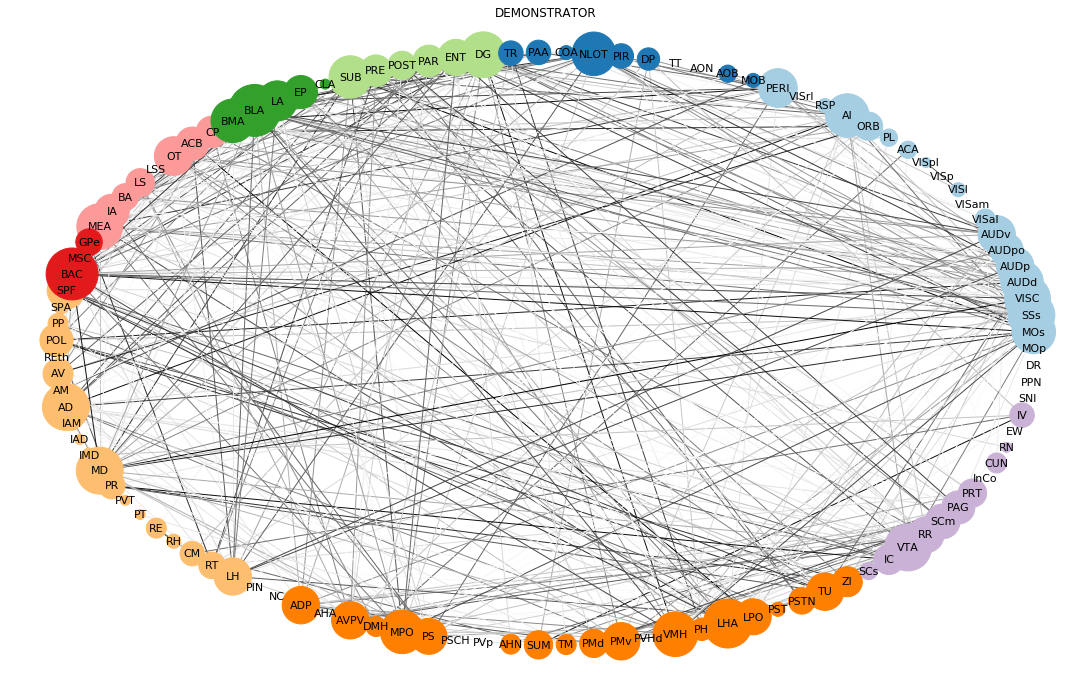

In [13]:
fig_graph_degrees(G=G_demonstrator, title='DEMONSTRATOR', volumes=volumes, figsize=(23,12), 
                  show_degrees=False, show_colorbar=False, show_legend=False, fontsize=11,
                 macroareas_to_exclude=macroareas_to_exclude)

(<Figure size 1656x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb3d8aa6da0>)

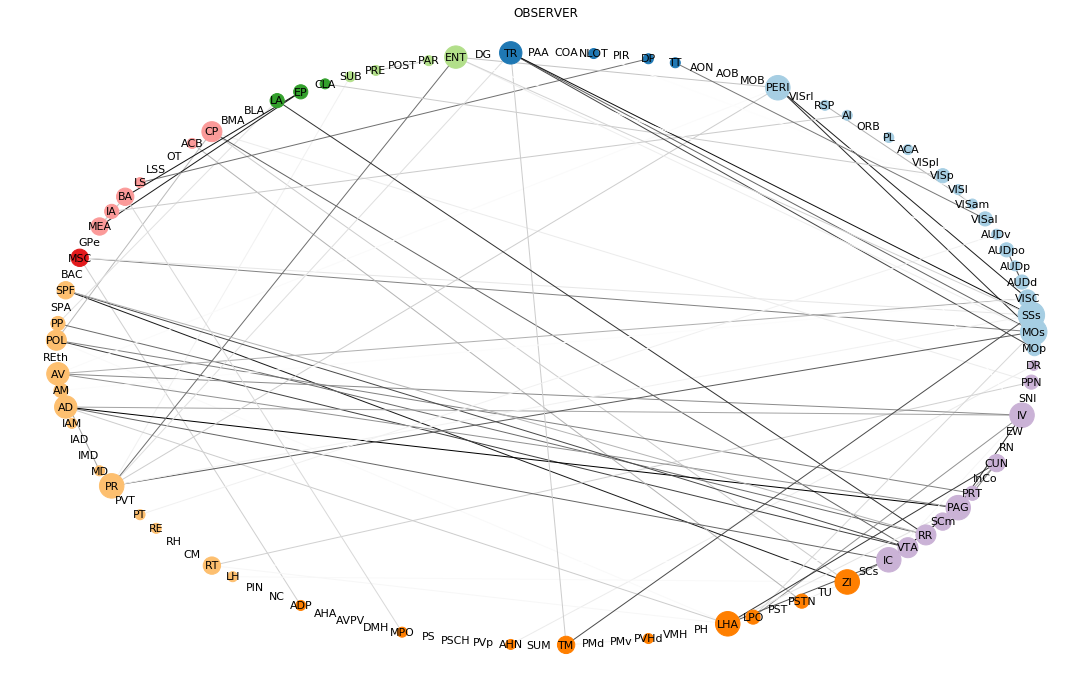

In [14]:
fig_graph_degrees(G=G_observer, title='OBSERVER', volumes=volumes, figsize=(23,12), 
                  show_degrees=False, show_colorbar=False, show_legend=False, fontsize=11,
                 macroareas_to_exclude=macroareas_to_exclude)

(<Figure size 1800x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb3d8e70e10>)

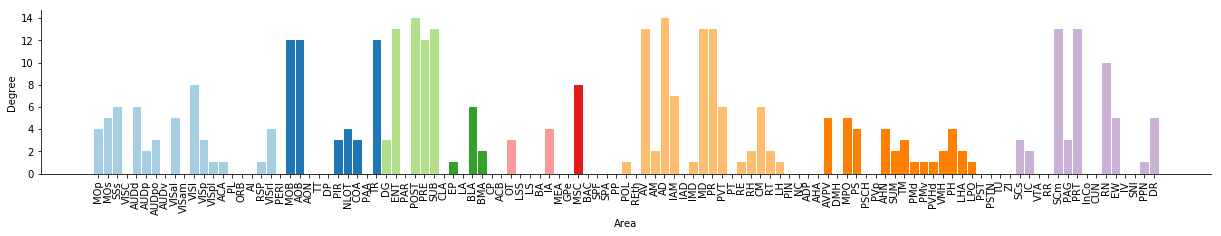

In [15]:
fig_graph_degrees(G=G_noshock, title='NO SHOCK', volumes=volumes, figsize=(25,3), 
                  show_degrees=True, show_colorbar=False, show_legend=False, show_graph=False,
                 macroareas_to_exclude=macroareas_to_exclude)


(<Figure size 1800x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb3d8cee2e8>)

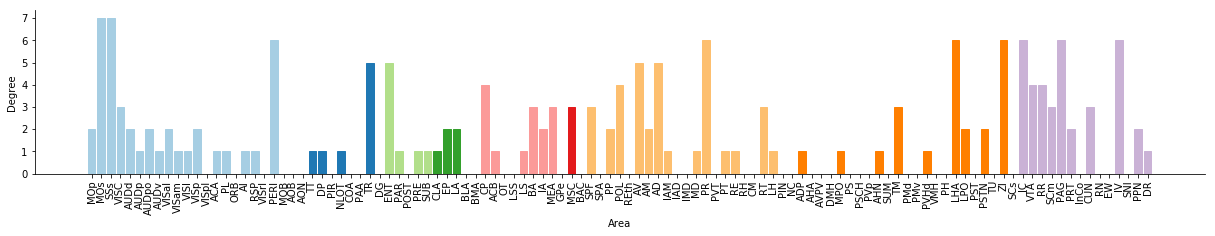

In [16]:
fig_graph_degrees(G=G_observer, title='OBSERVER', volumes=volumes, figsize=(25,3), 
                  show_degrees=True, show_colorbar=False, show_legend=False, show_graph=False,
                 macroareas_to_exclude=macroareas_to_exclude)


(<Figure size 1800x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb3d6e8c278>)

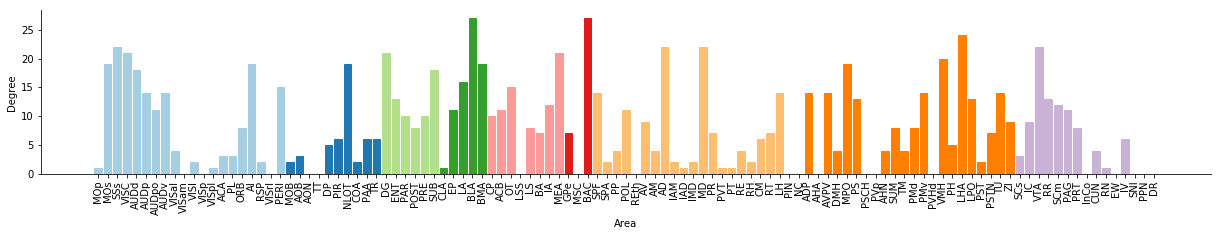

In [17]:
fig_graph_degrees(G=G_demonstrator, title='DEMONSTRATOR', volumes=volumes, figsize=(25,3), 
                  show_degrees=True, show_colorbar=False, show_legend=False, show_graph=False,
                 macroareas_to_exclude=macroareas_to_exclude)


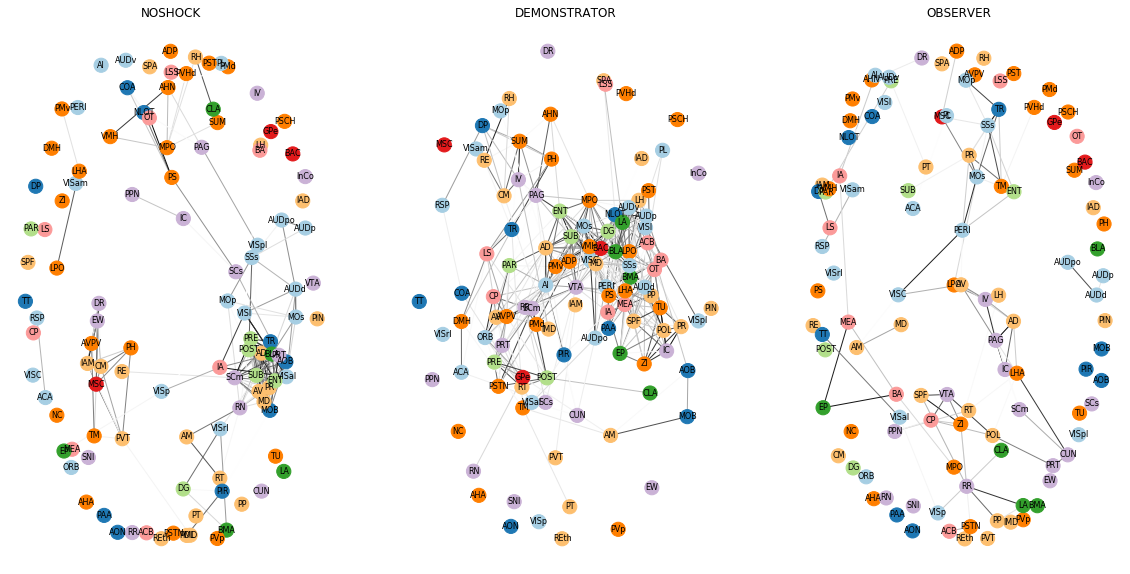

In [19]:
show_colorbar=True
show_legend=True
Gs = [G_noshock, G_demonstrator, G_observer]
titles=['NOSHOCK', 'DEMONSTRATOR', 'OBSERVER']
# create tables
allen_order = list(volumes[volumes['st_level']==8]['acronym'])
df_levels = upls.create_df_levels(volumes, level=8)

# create figure
fig = plt.figure(figsize=(20, 10))

edge_cmap = plt.cm.get_cmap('Greys')

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(1, 3)
# plot graph
for i, G in enumerate(Gs):
    ax = fig.add_subplot(axgrid[i])

    order=allen_order

    # Plot the network:
    # pos = nx.spring_layout(sorted(list(G.nodes()),
    #   key = order.index))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    list_colors = get_colors(G, df_levels, order, volumes=volumes,
                 macroareas_to_exclude=macroareas_to_exclude)[0]
    nx.draw(G, with_labels=True, node_color=list_colors, 
            node_size=200,font_size=8, pos=pos, ax=ax, edge_cmap=edge_cmap, width=1,
            edge_color=[G[u][v]['weight'] for u, v in G.edges])

    # relabel graphs
    ax.set_title(titles[i])


## Histogram degrees

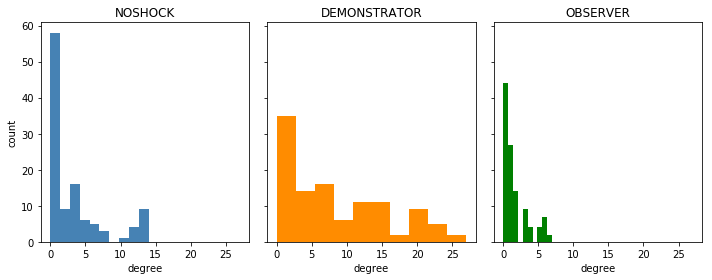

In [20]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axes[0].set_title('NOSHOCK')
axes[0].hist(list(dict(G_noshock.degree).values()),
            color='steelblue')
axes[1].set_title('DEMONSTRATOR')
axes[1].hist(list(dict(G_demonstrator.degree).values()),
            color='darkorange')
axes[2].set_title('OBSERVER')
axes[2].hist(list(dict(G_observer.degree).values()),
            color='green')
for i in range(3):
    axes[i].set_xlabel('degree')
axes[0].set_ylabel('count')
plt.tight_layout()
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree.svg')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree.png')

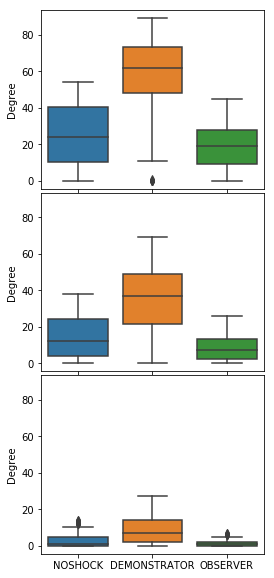

In [21]:
dfs = []
for threshold in [0.75, 0.85, 0.95]:
    noshock = create_graph(corr_matrix_noshock, volumes=volumes, 
                             significant_areas=significant_areas, 
                             corr_threshold=threshold, correlations='one')

    demonstrator = create_graph(corr_matrix_demonstrator,  volumes=volumes, 
                             significant_areas=significant_areas, 
                             corr_threshold=threshold, correlations='one')

    observer = create_graph(corr_matrix_observer,  volumes=volumes, 
                             significant_areas=significant_areas, 
                             corr_threshold=threshold, correlations='one')

    dfs.append(pd.DataFrame({'NOSHOCK':list(dict(noshock.degree).values()), 
                               'DEMONSTRATOR': list(dict(demonstrator.degree).values()), 
                               'OBSERVER':list(dict(observer.degree).values())}))
fig, ax = plt.subplots(3,1, sharey=True, figsize=(4,10))
plt.subplots_adjust(hspace=0.02)
for i in range(len([0.75, 0.85, 0.95])):
    sns.boxplot(data=dfs[i], ax=ax[i])
    ax[i].set_ylabel('Degree')
    if i!=2:
        ax[i].set_xticklabels('')
# ax[2].set_xlabel('Condition')

## Histogram weights

## Overall correlations

Text(0.5, 0.98, 'Correlations of all areas')

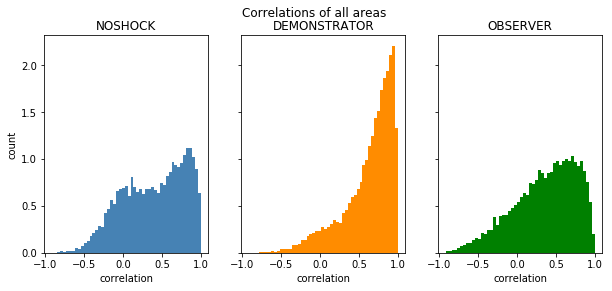

In [22]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
colors = ['steelblue', 'darkorange', 'green']
for i, corr in enumerate([corr_matrix_noshock, 
                          corr_matrix_demonstrator, 
                          corr_matrix_observer]):
    axes[i].hist(corr.mask(np.triu(np.ones(corr.shape)).astype(bool)).stack().values,
            color=colors[i], bins=50, density=True)
axes[0].set_title('NOSHOCK')
axes[1].set_title('DEMONSTRATOR')
axes[2].set_title('OBSERVER')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlations of all areas')

In [25]:
def fig_top_degrees(G, volumes, ax, macroareas_to_exclude, n=None, fontsize=12, y_lim=None):
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes, level=8)


    df = pd.DataFrame(columns=['area', 'degree', 'color'])
    df['area'] = sorted(list(G.nodes()), key = allen_order.index)
    df['degree'] = [G.degree()[area] for area in df['area']]
    df['color'] = get_colors(G,
                              df_levels=df_levels,
                              order=allen_order,
                              sorting=True,
                              volumes=volumes,
                 macroareas_to_exclude=macroareas_to_exclude)[0]
    df.sort_values(by='degree', ascending=False, inplace=True, ignore_index=True)

    if n==None:
        n=len(df)
    sns.barplot(data=df[0:n], x='area', y='degree', palette=df['color'], ax=ax)

    ax.set_ylabel("Degree")
    ax.set_xlabel("Area")
    # SET Y LIM
    if y_lim is not None:
        ax.set_ylim(0,y_lim)
    ax.tick_params(axis='x', labelrotation=90)
    sns.despine(left=False, bottom=False)
    ax.set_xlabel('')
    return ax

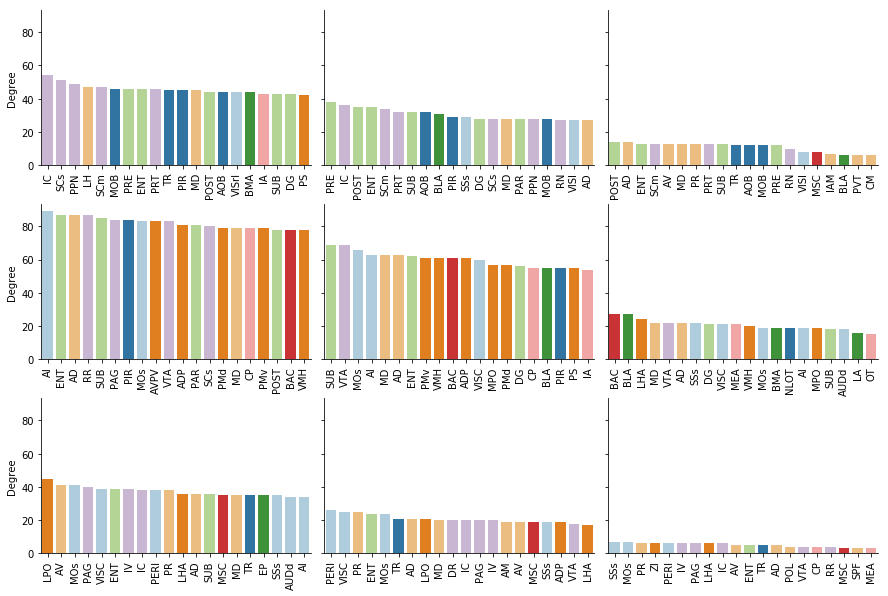

In [26]:
fig, axes = plt.subplots(3,3, figsize=(15,10), sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.25)

for i, threshold in enumerate([0.75, 0.85, 0.95]):
    noshock = create_graph(corr_matrix_noshock, volumes=volumes, 
                             significant_areas=significant_areas, 
                             corr_threshold=threshold, correlations='one')

    demonstrator = create_graph(corr_matrix_demonstrator,  volumes=volumes, 
                             significant_areas=significant_areas, 
                             corr_threshold=threshold, correlations='one')

    observer = create_graph(corr_matrix_observer,  volumes=volumes, 
                             significant_areas=significant_areas, 
                             corr_threshold=threshold, correlations='one')
    Gs = [noshock, demonstrator, observer]
    for j in range(len(Gs)):
        fig_top_degrees(G=Gs[j], ax=axes[j][i], volumes=volumes, n=20,
                    fontsize=12,
                 macroareas_to_exclude=macroareas_to_exclude)
        if i!=0:
            axes[j][i].set_ylabel('')
plt.savefig('ordered_degrees.png', dpi=300)

# Degree centrality

Text(0, 0.5, 'Average degree Centrality')

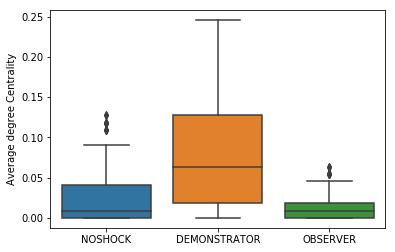

In [28]:
fig, axes = plt.subplots(1,1)
graphs=[G_noshock, G_demonstrator, G_observer]
degree_centrality = [nx.degree_centrality(G) for G in graphs]
df_degree_centrality = pd.DataFrame({'NOSHOCK': list(degree_centrality[0].values()), 
                                'DEMONSTRATOR': list(degree_centrality[1].values()),
                                'OBSERVER': list(degree_centrality[2].values())})
sns.boxplot(data=df_degree_centrality, ax=axes)
axes.set_ylabel('Average degree Centrality')

In [29]:
def plot_degree_centrality(graphs, volumes, macroareas_to_exclude, figsize=(10,8)):
    graphs_titles = ['NOSHOCK', 'DEMONSTRATOR', 'OBSERVER']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes, level=8)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=figsize)
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes,
                 macroareas_to_exclude=macroareas_to_exclude)[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        degree_centrality = [nx.degree_centrality(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= degree_centrality)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes,
                 macroareas_to_exclude=macroareas_to_exclude)[0]):
            axes[i].get_children()[idx].set_color(color)
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Degree Centrality")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

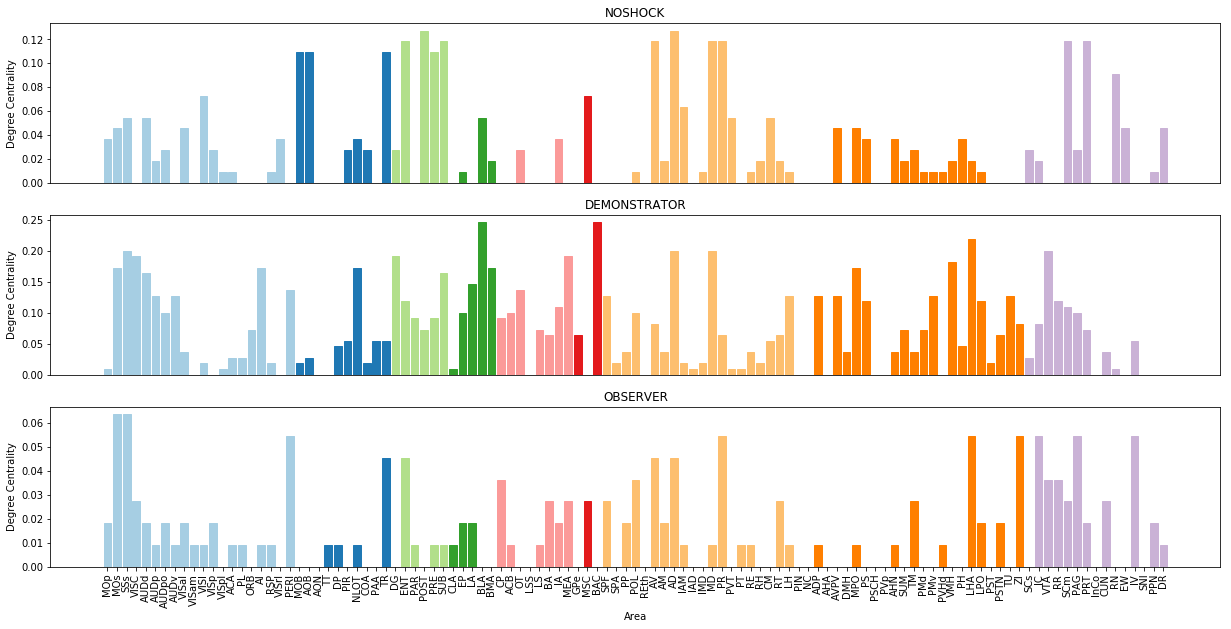

In [30]:
plot_degree_centrality(graphs=[G_noshock, G_demonstrator, G_observer], volumes=volumes, figsize=(25,10),
                 macroareas_to_exclude=macroareas_to_exclude)

In [31]:
def fig_top_centrality(G, volumes, ax, macroareas_to_exclude, n=None, fontsize=12, y_lim=None):
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes, level=8)


    df = pd.DataFrame(columns=['area', 'degree', 'color'])
    df['area'] = sorted(list(G.nodes()), key = allen_order.index)
    df['degree'] = [nx.degree_centrality(G)[area] for area in df['area']]
    df['color'] = get_colors(G,
                              df_levels=df_levels,
                              order=allen_order,
                              sorting=True,
                              volumes=volumes,
                 macroareas_to_exclude=macroareas_to_exclude)[0]
    df.sort_values(by='degree', ascending=False, inplace=True, ignore_index=True)

    if n==None:
        n=len(df)
    sns.barplot(data=df[0:n], x='area', y='degree', palette=df['color'], ax=ax)

    ax.set_ylabel("Degree Centrality")
    ax.set_xlabel("Area")
    # SET Y LIM
    if y_lim is not None:
        ax.set_ylim(0,y_lim)
    ax.tick_params(axis='x', labelrotation=90)
    sns.despine(left=False, bottom=False)
    ax.set_xlabel('')
    return ax

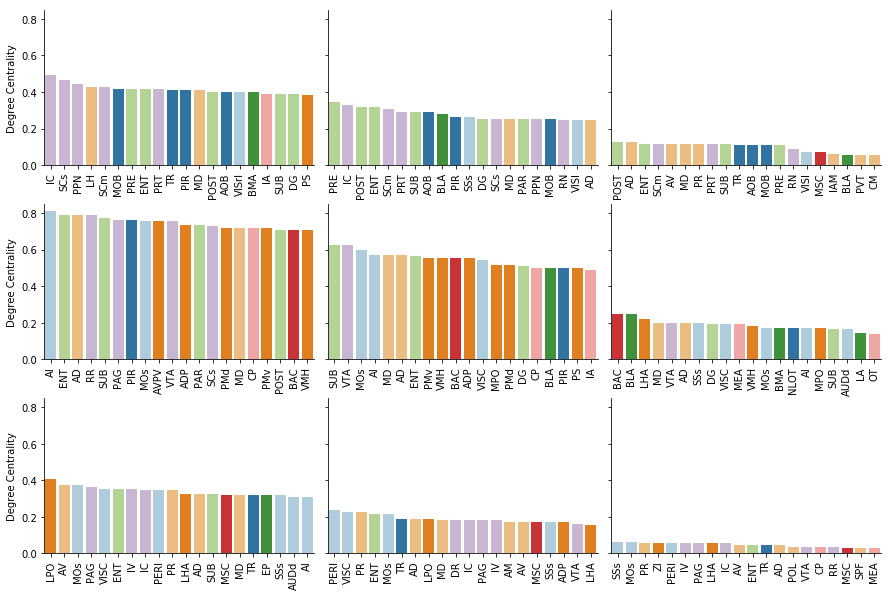

In [32]:
fig, axes = plt.subplots(3,3, figsize=(15,10), sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.25)

for i, threshold in enumerate([0.75, 0.85, 0.95]):
    noshock = create_graph(corr_matrix_noshock, volumes=volumes, 
                             significant_areas=significant_areas, 
                             corr_threshold=threshold, correlations='one')

    demonstrator = create_graph(corr_matrix_demonstrator,  volumes=volumes, 
                             significant_areas=significant_areas, 
                             corr_threshold=threshold, correlations='one')

    observer = create_graph(corr_matrix_observer,  volumes=volumes, 
                             significant_areas=significant_areas, 
                             corr_threshold=threshold, correlations='one')
    Gs = [noshock, demonstrator, observer]
    for j in range(len(Gs)):
        fig_top_centrality(G=Gs[j], ax=axes[j][i], volumes=volumes, n=20,
                    fontsize=12,
                 macroareas_to_exclude=macroareas_to_exclude)
        if i!=0:
            axes[j][i].set_ylabel('')
plt.savefig('ordered_centrality.png', dpi=300)